<a href="https://colab.research.google.com/github/isdeniz/paper-24/blob/main/nlbse22_roberta_case6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import unicodedata as ud
from nltk.corpus import wordnet as wn
from nltk.corpus import words as w
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import os
pd.set_option('display.max_colwidth', None)

#Retrieving datasets

In [2]:
test = pd.read_csv('/content/drive/My Drive/nlbse22/github-labels-top3-803k-test.csv')
train = pd.read_csv('/content/drive/My Drive/nlbse22/github-labels-top3-803k-train.csv')
print('test:', test.shape, 'train:', train.shape)

test: (80518, 8) train: (722899, 8)


In [3]:
train.head()

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,issue_title,issue_body
0,0,https://api.github.com/repos/eamodio/vscode-gitlens/issues/1302,bug,2021-01-02T18:07:30Z,NONE,https://api.github.com/repos/eamodio/vscode-gitlens,Welcome screen on every editor window is very tedious,"I just discovered Gitlens and find the functionality useful, thank you to all who contribute.\r\n\r\nI have about a dozen editor windows open, and the install process added a Gitlens welcome tab to each and every one of them. Combined with the snowflake effect, all of the sudden VScode was consuming 300-400% cpu and my fan was raging, as soon as I hunted them all down everything was back to fine. The welcome note content is great (although putting it on _all_ the windows is a bit much, don't know how much control you have on that). But overall it was a bit of a sour first-use experience, just wanted to provide that feedback."
1,1,https://api.github.com/repos/binwiederhier/pcopy/issues/9,bug,2020-12-31T18:19:31Z,OWNER,https://api.github.com/repos/binwiederhier/pcopy,"""pcopy invite"" and ""pcopy paste abc:"" does not check if clipboard exists",NaN
2,2,https://api.github.com/repos/binwiederhier/pcopy/issues/16,bug,2021-01-03T04:33:36Z,OWNER,https://api.github.com/repos/binwiederhier/pcopy,"UI: Modal overlay is half transparent, shouldn't be",NaN
3,3,https://api.github.com/repos/Sothatsit/RoyalUrClient/issues/41,enhancement,2020-12-25T00:46:00Z,OWNER,https://api.github.com/repos/Sothatsit/RoyalUrClient,Make the loading screen scale with browser window size,"Currently the loading wheel is a fixed size in pixels, but it would be better to specify it in terms of percentage of the browser size."
4,4,https://api.github.com/repos/Malivil/TTT-Custom-Roles/issues/190,bug,2021-01-02T21:36:57Z,OWNER,https://api.github.com/repos/Malivil/TTT-Custom-Roles,Spectator - Investigate a way to strip weapons before they are spectating a player,To bring magneto stick floating


In [4]:
test.head()

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,issue_title,issue_body
0,6,https://api.github.com/repos/tlnagy/TIFF.jl/issues/7,enhancement,2020-04-07T09:08:50Z,NONE,https://api.github.com/repos/tlnagy/TIFF.jl,"ERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0x0008) not found","One more error might need to be caught.\r\n`4D-series.ome.tif` is sample file from [OME-TIFF website]( https://docs.openmicroscopy.org/ome-model/6.0.0/ome-tiff/data.html).\r\n\r\n```julia\r\njulia> TIFF.load(""4D-series.ome.tif"")\r\nERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0x0008) not found\r\nStacktrace:\r\n [1] getindex(::Dict{Tuple{TIFF.SampleFormats,Int64},DataType}, ::Tuple{TIFF.SampleFormats,UInt16}) at ./dict.jl:477\r\n [2] output(::TIFF.IFD{UInt32}) at /home/hf/.julia/dev/TIFF/src/ifds.jl:113\r\n [3] load(::String) at /home/hf/.julia/dev/TIFF/src/load.jl:14\r\n [4] top-level scope at REPL[2]:1\r\n```\r\n"
1,19,https://api.github.com/repos/tisboyo/Twitch_Bot/issues/57,enhancement,2020-11-27T07:17:21Z,OWNER,https://api.github.com/repos/tisboyo/Twitch_Bot,Add database backup to dropbox,NaN
2,25,https://api.github.com/repos/DrWhoCares/imgdanke/issues/70,enhancement,2021-01-02T19:35:34Z,OWNER,https://api.github.com/repos/DrWhoCares/imgdanke,Add a button/method to open the Source or Output folders,"Could also add a method to open up path to each file in the File list, by right-clicking.\r\nAlso an option to open up the path to the imgdanke.exe."
3,30,https://api.github.com/repos/DrWhoCares/imgdanke/issues/72,bug,2021-01-02T20:55:34Z,OWNER,https://api.github.com/repos/DrWhoCares/imgdanke,Processes are being started twice,At some point I refactored a few things and ended up leaving in an additional call to `process.Start()` that should've just been replaced by the `using Process process = Process.Start()` call.
4,54,https://api.github.com/repos/Bean-1/AOT/issues/3,bug,2020-12-29T15:34:35Z,OWNER,https://api.github.com/repos/Bean-1/AOT,Cannot add hp to wall,NaN


#Preprocessing

Remove the issue reports from the training set which appear both in the training and tests

In [5]:
mask = train['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(count)

7086


In [6]:
mask = test['issue_url'].isin(train['issue_url'])
count = mask.sum()
print(count)

5550


In [7]:
mask = train['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(f"Number of rows to remove: {count}")

train_cleaned = train.copy(deep = True)

train_cleaned = train_cleaned[~mask]

print('Number of cleaned issues: ' , train.shape[0] - train_cleaned.shape[0], 'Final size of the train set: ', train_cleaned.shape[0])

Number of rows to remove: 7086
Number of cleaned issues:  7086 Final size of the train set:  715813


In [8]:
mask = train_cleaned['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(count)

0


In [9]:
mask = test['issue_url'].isin(train_cleaned['issue_url'])
count = mask.sum()
print(count)

0


In [10]:
train_cleaned['issue_label'].value_counts()

,count
issue_label,
bug,357293
enhancement,297000
question,61520


In [11]:
test['issue_label'].value_counts()

,count
issue_label,
bug,40288
enhancement,33203
question,7027


In [12]:
train_cleaned['original_issue_title'] = train_cleaned['issue_title']
train_cleaned['original_issue_body'] = train_cleaned['issue_body']

train_cleaned.rename(columns={'issue_title': 'preprocessed_title'}, inplace=True)
train_cleaned.rename(columns={'issue_body': 'preprocessed_body'}, inplace=True)

test['original_issue_title'] = test['issue_title']
test['original_issue_body'] = test['issue_body']

test.rename(columns={'issue_title': 'preprocessed_title'}, inplace=True)
test.rename(columns={'issue_body': 'preprocessed_body'}, inplace=True)

In [13]:
label = 'issue_label'
time = 'issue_created_at'
repo = 'repository_url'
title  = 'preprocessed_title'
body = 'preprocessed_body'
author = 'issue_author_association'
url = 'issue_url'
label_col = 'labels'
text_col = 'text'
max_title = 30
max_body = 170
# punctuations = '!"$%&\()*,/:;<=>[\\]^`{|}~+#@-`' below line is added since this line (original) gives SyntaxWarning: invalid escape sequence '\('
punctuations = r'!"$%&\()*,/:;<=>[\\]^`{|}~+#@-`'
ascii_regex = re.compile(r'[^\x00-\x7f]')
issue_regex = re.compile(r'#[0-9]+')
function_regex = re.compile(r'[a-zA-Z][a-zA-Z0-9_.]*\([a-zA-Z0-9_, ]*\)')

deduplicate the TRAINING dataset based on issue URls

In [14]:
dedup_train = train_cleaned.sort_values(url).drop_duplicates(subset=[url]).copy()
print('Number of dropped issue duplications: ' , train_cleaned.shape[0] - dedup_train.shape[0])

dedup_train[title] = dedup_train[title].astype(str)
dedup_train[body] = dedup_train[body].astype(str)
dedup_train[author] = dedup_train[author].astype(str)
dedup_train[time] = dedup_train[time].astype(str)
dedup_train[repo] = dedup_train[repo].astype(str)

test[title] = test[title].astype(str)
test[body] = test[body].astype(str)
test[author] = test[author].astype(str)
test[time] = test[time].astype(str)
test[repo] = test[repo].astype(str)

Number of dropped issue duplications:  24560


In [15]:
mask = dedup_train['issue_url'].isin(test['issue_url'])
count = mask.sum()
print(count)

0


In [16]:
mask = test['issue_url'].isin(dedup_train['issue_url'])
count = mask.sum()
print(count)

0


text normalization on text columns of issues

In [17]:
print('Replacing functions...')
dedup_train[body] = dedup_train[body].apply(lambda x:function_regex.sub(" function ",x))
test[body] = test[body].apply(lambda x:function_regex.sub(" function ",x))

print('Replacing issue numbers...')
dedup_train[title] = dedup_train[title].apply(lambda x:issue_regex.sub(" issue ",x))
dedup_train[body] = dedup_train[body].apply(lambda x:issue_regex.sub(" issue ",x))
test[title] = test[title].apply(lambda x:issue_regex.sub(" issue ",x))
test[body] = test[body].apply(lambda x:issue_regex.sub(" issue ",x))

print('Converting to lower case...')
dedup_train[title] = dedup_train[title].str.lower()
dedup_train[body] = dedup_train[body].str.lower()
test[title] = test[title].str.lower()
test[body] = test[body].str.lower()

Replacing functions...
Replacing issue numbers...
Converting to lower case...


remove extra information from text

In [18]:
print('Removing punctuations...')
replace_string = ' '*len(punctuations)
dedup_train[title] = dedup_train[title].str.translate(str.maketrans(punctuations, replace_string))
dedup_train[body] = dedup_train[body].str.translate(str.maketrans(punctuations, replace_string))
test[title] = test[title].str.translate(str.maketrans(punctuations, replace_string))
test[body] = test[body].str.translate(str.maketrans(punctuations, replace_string))

print('Removing non-ascii charachters...')
dedup_train[title] = dedup_train[title].apply(lambda x:re.sub(ascii_regex, '', x))
dedup_train[title] = dedup_train[title].apply(lambda x:ud.normalize('NFD', x))
dedup_train[body] = dedup_train[body].apply(lambda x:re.sub(ascii_regex, '', x))
dedup_train[body] = dedup_train[body].apply(lambda x:ud.normalize('NFD', x))

test[title] = test[title].apply(lambda x:re.sub(ascii_regex, '', x))
test[title] = test[title].apply(lambda x:ud.normalize('NFD', x))
test[body] = test[body].apply(lambda x:re.sub(ascii_regex, '', x))
test[body] = test[body].apply(lambda x:ud.normalize('NFD', x))

print('Replacing fixed part of repo URl column...')
dedup_train[repo] = dedup_train[repo].apply(lambda x: x.replace('https://api.github.com/repos/', ''))
test[repo] = test[repo].apply(lambda x: x.replace('https://api.github.com/repos/', ''))

print('Replacing white spaces...')
dedup_train[title] = dedup_train[title].apply(lambda x:" ".join(x.split()))
dedup_train[body] = dedup_train[body].apply(lambda x:" ".join(x.split()))
test[title] = test[title].apply(lambda x:" ".join(x.split()))
test[body] = test[body].apply(lambda x:" ".join(x.split()))

Removing punctuations...
Removing non-ascii charachters...
Replacing fixed part of repo URl column...
Replacing white spaces...


check the number of tokens in the issue title and issue body

Train

In [19]:
dedup_train['title_token_count'] = dedup_train[title].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue title: {dedup_train['title_token_count'].mean()}, Median of tokens in issue title: {dedup_train['title_token_count'].median()}")

Average number of tokens in issue title: 6.763788366922096, Median of tokens in issue title: 6.0


In [20]:
dedup_train['body_token_count'] = dedup_train[body].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue body: {dedup_train['body_token_count'].mean()}, Median of tokens in issue body: {dedup_train['body_token_count'].median()}")

Average number of tokens in issue body: 117.1536326062961, Median of tokens in issue body: 49.0


Test

In [21]:
test['title_token_count'] = test[title].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue title: {test['title_token_count'].mean()}, Median of tokens in issue title: {test['title_token_count'].median()}")

Average number of tokens in issue title: 6.7562284209741925, Median of tokens in issue title: 6.0


In [22]:
test['body_token_count'] = test[body].apply(lambda x: len(x.split()))
print(f"Average number of tokens in issue body: {test['body_token_count'].mean()}, Median of tokens in issue body: {test['body_token_count'].median()}")

Average number of tokens in issue body: 117.74881392980451, Median of tokens in issue body: 49.0


truncate columns

In [23]:
dedup_train[title] = dedup_train[title].apply(lambda x: ' '.join(x.split(maxsplit=max_title)[:max_title]))
dedup_train[body] = dedup_train[body].apply(lambda x: ' '.join(x.split(maxsplit=max_body)[:max_body]))
test[title] = test[title].apply(lambda x: ' '.join(x.split(maxsplit=max_title)[:max_title]))
test[body] = test[body].apply(lambda x: ' '.join(x.split(maxsplit=max_body)[:max_body]))

prepare labels column

In [24]:
dedup_train[label] = pd.Categorical(dedup_train[label])
test[label] = pd.Categorical(test[label])
dedup_train[label_col] = dedup_train[label].cat.codes
test[label_col] = test[label].cat.codes

concat issue columns in one "text" column to feed the BERT model

In [25]:
dedup_train[text_col] = 'time ' + dedup_train[time] + ' title ' + dedup_train[title] + ' body ' + dedup_train[body]
test[text_col] = 'time ' + test[time] + ' title ' + test[title] + ' body ' + test[body]

In [26]:
dedup_train.head(1)

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,preprocessed_title,preprocessed_body,original_issue_title,original_issue_body,title_token_count,body_token_count,labels,text
258501,287489,https://api.github.com/repos/0-Yama/Projet-Final-Python/issues/3,enhancement,2021-05-26T20:57:00Z,OWNER,0-Yama/Projet-Final-Python,the beginning,we need to add the first file of our project,The beginning,We need to add the first file of our project,2,10,1,time 2021-05-26T20:57:00Z title the beginning body we need to add the first file of our project


In [27]:
test.head(1)

,Unnamed: 0,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,preprocessed_title,preprocessed_body,original_issue_title,original_issue_body,title_token_count,body_token_count,labels,text
0,6,https://api.github.com/repos/tlnagy/TIFF.jl/issues/7,enhancement,2020-04-07T09:08:50Z,NONE,tlnagy/TIFF.jl,error keyerror key tiff.sampleformat_int 0x0008 not found,one more error might need to be caught. 4d series.ome.tif is sample file from ome tiff website https docs.openmicroscopy.org ome model 6.0.0 ome tiff data.html . julia julia tiff.load 4d series.ome.tif error keyerror key tiff.sampleformat_int 0x0008 not found stacktrace 1 getindex dict tuple tiff.sampleformats int64 datatype tuple tiff.sampleformats uint16 at . dict.jl 477 2 output tiff.ifd uint32 at home hf .julia dev tiff src ifds.jl 113 3 load string at home hf .julia dev tiff src load.jl 14 4 top level scope at repl 2 1,"ERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0x0008) not found","One more error might need to be caught.\r\n`4D-series.ome.tif` is sample file from [OME-TIFF website]( https://docs.openmicroscopy.org/ome-model/6.0.0/ome-tiff/data.html).\r\n\r\n```julia\r\njulia> TIFF.load(""4D-series.ome.tif"")\r\nERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0x0008) not found\r\nStacktrace:\r\n [1] getindex(::Dict{Tuple{TIFF.SampleFormats,Int64},DataType}, ::Tuple{TIFF.SampleFormats,UInt16}) at ./dict.jl:477\r\n [2] output(::TIFF.IFD{UInt32}) at /home/hf/.julia/dev/TIFF/src/ifds.jl:113\r\n [3] load(::String) at /home/hf/.julia/dev/TIFF/src/load.jl:14\r\n [4] top-level scope at REPL[2]:1\r\n```\r\n",7,86,1,time 2020-04-07T09:08:50Z title error keyerror key tiff.sampleformat_int 0x0008 not found body one more error might need to be caught. 4d series.ome.tif is sample file from ome tiff website https docs.openmicroscopy.org ome model 6.0.0 ome tiff data.html . julia julia tiff.load 4d series.ome.tif error keyerror key tiff.sampleformat_int 0x0008 not found stacktrace 1 getindex dict tuple tiff.sampleformats int64 datatype tuple tiff.sampleformats uint16 at . dict.jl 477 2 output tiff.ifd uint32 at home hf .julia dev tiff src ifds.jl 113 3 load string at home hf .julia dev tiff src load.jl 14 4 top level scope at repl 2 1


In [28]:
dedup_train['issue_label'].value_counts()

,count
issue_label,
bug,344994
enhancement,288015
question,58244


In [29]:
test['issue_label'].value_counts()

,count
issue_label,
bug,40288
enhancement,33203
question,7027


In [30]:
dedup_train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [31]:
dedup_train[['original_issue_title','preprocessed_title','original_issue_body','preprocessed_body','text','issue_label','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case6/train_clean_concat_{max_title+max_body}_detailed_data.csv', index = False)
test[['original_issue_title','preprocessed_title','original_issue_body','preprocessed_body','text','issue_label','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case6/test_clean_concat_{max_title+max_body}_detailed_data.csv', index = False)

dedup_train[['text','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case6/train_clean_concat_{max_title+max_body}.csv', index = False)
test[['text','labels']].to_csv(f'/content/drive/My Drive/nlbse22/case6/test_clean_concat_{max_title+max_body}.csv', index = False)

#Roberta

In [32]:
pip install transformers==4.40.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.2 which is incompatible.


In [33]:
pip install simpletransformers==0.64.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
 

In [34]:
import transformers
>>> transformers.__version__

'4.40.2'

In [35]:
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.multiprocessing
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.multiprocessing.set_start_method('spawn', force = True)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


load and prepare data

In [36]:
train = pd.read_csv('/content/drive/My Drive/nlbse22/case6/train_clean_concat_200.csv')
test = pd.read_csv('/content/drive/My Drive/nlbse22/case6/test_clean_concat_200.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (691253, 2) (80518, 2)


In [37]:
train.head()

,text,labels
0,time 2021-05-26T20:57:00Z title the beginning body we need to add the first file of our project,1
1,time 2020-07-26T20:14:04Z title better touch tool configuration body export better touch tool configuration as a separate package or submodule,1
2,time 2020-12-04T09:33:18Z title request text when wand of regrowth starts producing furrowed grass body i was super confused when this happened. a bit of text would have helped me realize what was going on a lot sooner. the wand is getting old and the new grass is not as healthy. ?,1
3,time 2020-09-22T01:49:32Z title update total credits when cards are removed body total credits is only updated when adding new courses but is never updated when cards are removed,1
4,time 2020-09-22T01:52:14Z title delete course from matrix body there is no way to remove courses from the matrix once they have been added. don't forget to update the total credits see issue,1


In [38]:
test.head()

,text,labels
0,time 2020-04-07T09:08:50Z title error keyerror key tiff.sampleformat_int 0x0008 not found body one more error might need to be caught. 4d series.ome.tif is sample file from ome tiff website https docs.openmicroscopy.org ome model 6.0.0 ome tiff data.html . julia julia tiff.load 4d series.ome.tif error keyerror key tiff.sampleformat_int 0x0008 not found stacktrace 1 getindex dict tuple tiff.sampleformats int64 datatype tuple tiff.sampleformats uint16 at . dict.jl 477 2 output tiff.ifd uint32 at home hf .julia dev tiff src ifds.jl 113 3 load string at home hf .julia dev tiff src load.jl 14 4 top level scope at repl 2 1,1
1,time 2020-11-27T07:17:21Z title add database backup to dropbox body nan,1
2,time 2021-01-02T19:35:34Z title add a button method to open the source or output folders body could also add a method to open up path to each file in the file list by right clicking. also an option to open up the path to the imgdanke.exe.,1
3,time 2021-01-02T20:55:34Z title processes are being started twice body at some point i refactored a few things and ended up leaving in an additional call to function that should've just been replaced by the using process process function call.,0
4,time 2020-12-29T15:34:35Z title cannot add hp to wall body nan,0


set the classification layer and training parameters

In [39]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
max_seq = 200
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2 below line is added since this line (original) uses 2 GPUs but we have 1
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 3,
                                use_cuda=cuda_available)

    return model

define evaluation metrics

In [40]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict=True)
}

train the model

In [41]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df=train, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

----- roberta , start time: 06/12/2024-12:32 -----


  0%|          | 0/691253 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:884: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 0 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 1 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/6913 [00:00<?, ?it/s]

(27652, 0.3501081669911404)

evaluate the model

In [42]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test, verbose=True, **metrics_recom)
results

----- roberta , duration is: 1h:19m:31s ----- 




  0%|          | 0/80518 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/806 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1506: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': 0.7493974319517513,
 'accuracy': 0.85768399612509,
 'p_micro': 0.85768399612509,
 'p_macro': 0.8054577618586086,
 'p_w': 0.8552720592799301,
 'r_micro': 0.85768399612509,
 'r_macro': 0.7822521911142113,
 'r_w': 0.85768399612509,
 'f_micro': 0.85768399612509,
 'f_macro': 0.7926830297362772,
 'f_w': 0.8561433004870573,
 'classificationReport': {'0.0': {'precision': 0.8789320126510898,
   'recall': 0.8898183081810961,
   'f1-score': 0.8843416589577552,
   'support': 40288.0},
  '1.0': {'precision': 0.8653263645542555,
   'recall': 0.8776014215582929,
   'f1-score': 0.8714206677931128,
   'support': 33203.0},
  '2.0': {'precision': 0.6721149083704805,
   'recall': 0.5793368436032447,
   'f1-score': 0.6222867624579639,
   'support': 7027.0},
  'accuracy': 0.85768399612509,
  'macro avg': {'precision': 0.8054577618586086,
   'recall': 0.7822521911142113,
   'f1-score': 0.7926830297362772,
   'support': 80518.0},
  'weighted avg': {'precision': 0.8552720592799301,
   'recall': 0.85768

get the confusion matrix

In [43]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'enhancement', 'question'])

In [44]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['question']:
    return 2

In [45]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)

In [46]:
model_outputs_df['actual'] = test['labels']

In [47]:
label_names = ['bug', 'enhancement', 'question']

In [48]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

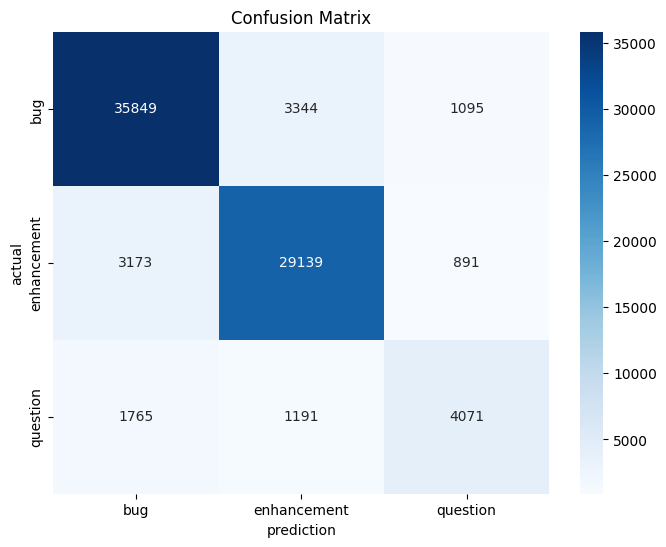

In [49]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

save predictions

In [50]:
predictions = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction'])

In [51]:
predictions['text'] = test['text']
predictions['labels'] = test['labels']
predictions['actual_labels'] = model_outputs_df['actual']
predictions['prediction'] = model_outputs_df['prediction']
predictions.head()

,text,labels,actual_labels,prediction
0,time 2020-04-07T09:08:50Z title error keyerror key tiff.sampleformat_int 0x0008 not found body one more error might need to be caught. 4d series.ome.tif is sample file from ome tiff website https docs.openmicroscopy.org ome model 6.0.0 ome tiff data.html . julia julia tiff.load 4d series.ome.tif error keyerror key tiff.sampleformat_int 0x0008 not found stacktrace 1 getindex dict tuple tiff.sampleformats int64 datatype tuple tiff.sampleformats uint16 at . dict.jl 477 2 output tiff.ifd uint32 at home hf .julia dev tiff src ifds.jl 113 3 load string at home hf .julia dev tiff src load.jl 14 4 top level scope at repl 2 1,1,1,0
1,time 2020-11-27T07:17:21Z title add database backup to dropbox body nan,1,1,1
2,time 2021-01-02T19:35:34Z title add a button method to open the source or output folders body could also add a method to open up path to each file in the file list by right clicking. also an option to open up the path to the imgdanke.exe.,1,1,1
3,time 2021-01-02T20:55:34Z title processes are being started twice body at some point i refactored a few things and ended up leaving in an additional call to function that should've just been replaced by the using process process function call.,0,0,0
4,time 2020-12-29T15:34:35Z title cannot add hp to wall body nan,0,0,0


In [52]:
predictions.to_csv('/content/drive/My Drive/nlbse22/case6/nlbse22_test_roberta_preds.csv')

In [53]:
predictions.to_pickle('/content/drive/My Drive/nlbse22/case6/nlbse22_test_roberta_preds.pkl')

Performance on training set

In [54]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_train, model_outputs_train, wrong_pred_train = model.eval_model(train, verbose=True, **metrics_recom)
results_train

----- roberta , duration is: 1h:20m:53s ----- 




  0%|          | 0/691253 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/6913 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1506: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': 0.8422295707947036,
 'accuracy': 0.9104944210007045,
 'p_micro': 0.9104944210007045,
 'p_macro': 0.8749854341411387,
 'p_w': 0.9092968452102619,
 'r_micro': 0.9104944210007045,
 'r_macro': 0.853760037199312,
 'r_w': 0.9104944210007045,
 'f_micro': 0.9104944210007045,
 'f_macro': 0.8636130428515404,
 'f_w': 0.9096877277146066,
 'classificationReport': {'0.0': {'precision': 0.9234408911246856,
   'recall': 0.9311524258392899,
   'f1-score': 0.9272806259191853,
   'support': 344994.0},
  '1.0': {'precision': 0.9177378421723199,
   'recall': 0.9278579240664548,
   'f1-score': 0.9227701370496852,
   'support': 288015.0},
  '2.0': {'precision': 0.7837775691264108,
   'recall': 0.7022697616921915,
   'f1-score': 0.7407883655857503,
   'support': 58244.0},
  'accuracy': 0.9104944210007045,
  'macro avg': {'precision': 0.8749854341411387,
   'recall': 0.853760037199312,
   'f1-score': 0.8636130428515404,
   'support': 691253.0},
  'weighted avg': {'precision': 0.9092968452102619,
   're

get the confusion matrix for training set

In [55]:
model_outputs_df_train = pd.DataFrame(model_outputs_train, columns = ['bug', 'enhancement', 'question'])
model_outputs_df_train['prediction'] = model_outputs_df_train.apply(get_prediction, axis = 1)
model_outputs_df_train['actual'] = train['labels']
predicted_labels_train = model_outputs_df_train['prediction']
actual_labels_train = model_outputs_df_train['actual']

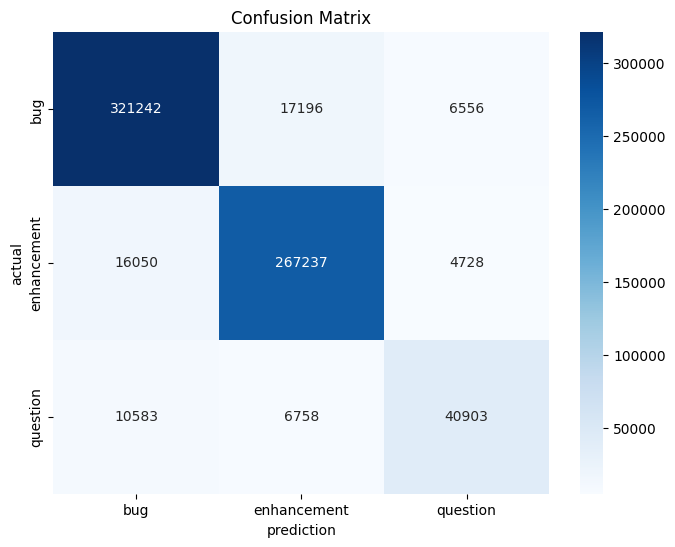

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

save predictions of training set

In [57]:
predictions_train = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction'])
predictions_train['text'] = train['text']
predictions_train['labels'] = train['labels']
predictions_train['actual_labels'] = model_outputs_df_train['actual']
predictions_train['prediction'] = model_outputs_df_train['prediction']
predictions_train.head()

,text,labels,actual_labels,prediction
0,time 2021-05-26T20:57:00Z title the beginning body we need to add the first file of our project,1,1,1
1,time 2020-07-26T20:14:04Z title better touch tool configuration body export better touch tool configuration as a separate package or submodule,1,1,1
2,time 2020-12-04T09:33:18Z title request text when wand of regrowth starts producing furrowed grass body i was super confused when this happened. a bit of text would have helped me realize what was going on a lot sooner. the wand is getting old and the new grass is not as healthy. ?,1,1,1
3,time 2020-09-22T01:49:32Z title update total credits when cards are removed body total credits is only updated when adding new courses but is never updated when cards are removed,1,1,0
4,time 2020-09-22T01:52:14Z title delete course from matrix body there is no way to remove courses from the matrix once they have been added. don't forget to update the total credits see issue,1,1,1


In [58]:
predictions_train.to_csv('/content/drive/My Drive/nlbse22/case6/nlbse22_train_roberta_preds.csv')
predictions_train.to_pickle('/content/drive/My Drive/nlbse22/case6/nlbse22_train_roberta_preds.pkl')